In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import tensorboard
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers

In [2]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

2022-10-10 08:50:02.069061: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1D generation

## Experiment 1
We generate from a multiplicative Y = AX.  
A is a gamma distribution with alpha = 3, beta = 0.5  
X is a inverse gamma distribution with alpha = 2.5, beta = 0.6  
The prior is InvGamma with alpha=2.5, beta=1   
The posterior is InvGamma with alpha = 3, beta learnable function of samples y  
The likelihood is a gamma distribution with alpha = 3 , beta learnable function of samples y  

In [3]:
tfd = tfp.distributions
encoded_size = 1
input_shape =(1,)
nbparamsl = 2
nbparamsobs = 2


In [5]:
A = tfd.Gamma(concentration = 3.0, rate=0.5).sample(1000)
X = tfd.InverseGamma(concentration =2.5, scale = 0.6 ).sample(1000)

Y=A*X
train_dataset = Y[:750]
train_dataset = tf.reshape(train_dataset,[750,1])
eval_dataset = Y[750:]
eval_dataset=tf.reshape(eval_dataset,[250,1])
print(eval_dataset)

2022-10-05 11:53:09.228574: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


tf.Tensor(
[[ 3.5803611 ]
 [ 0.9649158 ]
 [ 1.1804842 ]
 [ 1.1554612 ]
 [ 1.9798651 ]
 [ 1.0881157 ]
 [ 0.4741593 ]
 [ 0.22571002]
 [ 2.730163  ]
 [ 3.259333  ]
 [ 1.8155164 ]
 [ 2.7796144 ]
 [ 0.6543955 ]
 [ 1.4752116 ]
 [ 1.580921  ]
 [ 1.9853787 ]
 [ 1.421138  ]
 [ 0.99521655]
 [ 8.911227  ]
 [ 3.6052806 ]
 [ 0.5588802 ]
 [ 5.171445  ]
 [ 4.5441766 ]
 [ 3.110975  ]
 [ 2.843755  ]
 [ 1.7015367 ]
 [ 2.4710555 ]
 [ 2.7447038 ]
 [ 0.93109906]
 [ 1.1274384 ]
 [ 0.86662763]
 [ 0.87006795]
 [ 3.7824965 ]
 [ 1.022854  ]
 [ 2.4885077 ]
 [ 6.9109316 ]
 [ 1.6415321 ]
 [ 0.582364  ]
 [ 1.0547955 ]
 [ 0.77432275]
 [ 0.8157321 ]
 [ 0.6872637 ]
 [ 0.60317755]
 [ 3.758479  ]
 [ 2.0099344 ]
 [ 1.2354636 ]
 [ 3.4572089 ]
 [ 4.670063  ]
 [ 3.2245235 ]
 [ 5.86951   ]
 [ 1.2262657 ]
 [ 0.78107363]
 [ 1.2609036 ]
 [ 2.7206373 ]
 [18.419289  ]
 [ 1.2494375 ]
 [ 1.3611931 ]
 [ 4.8134513 ]
 [ 1.6396108 ]
 [ 1.6906953 ]
 [ 0.40109894]
 [ 0.8948262 ]
 [ 6.195347  ]
 [ 1.4573697 ]
 [ 2.0143507 ]
 [ 2.4858427 ]

/home/nlafon/.conda/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


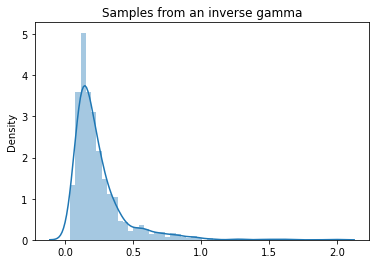

In [6]:
import inspect
#inspect.getargspec(tfd.InverseGamma)
invG = tfd.InverseGamma(concentration = 3, scale =0.5)
samples = invG.sample(1000)

sns.distplot(samples)
plt.title("Samples from an inverse gamma")
plt.show()


In [6]:
prior =tfd.InverseGamma(concentration =2.5, scale = 1 )

In [118]:
tfpl = tfp.layers
encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[1]),
    tfkl.Dense(1,
               activation=None),
    tfkl.Lambda(lambda x: tf.abs(x)+0.001),
    tfpl.DistributionLambda(
    make_distribution_fn=lambda t: tfd.InverseGamma(
        concentration=3, scale=t),
    activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
])

In [119]:
c=tf.constant([[1.0],[2.0]])
print(encoder(c))
[print(np.squeeze(w.numpy())) for w in encoder.weights]

tfp.distributions._TensorCoercible("sequential_8_distribution_lambda_9_tensor_coercible", batch_shape=[2, 1], event_shape=[], dtype=float32)
1.272061
0.0


[None, None]

In [133]:
decoder = tfk.Sequential([
    tfkl.Dense(5, use_bias=True, activation='relu'),
    tfkl.Dense(5, use_bias=True, activation='relu'),
    tfkl.Dense(1, use_bias=True),
    tfkl.Lambda(lambda x: tf.abs(x)+0.001),
    tfpl.DistributionLambda(
    make_distribution_fn=lambda v: tfd.Gamma(
        concentration=3, rate=v)),
 #   convert_to_tensor_fn=lambda s: s.sample),
])

In [134]:
c=tf.constant([[1.0],[2.4]])
print(decoder(c))
[print(np.squeeze(w.numpy())) for w in decoder.weights]

tfp.distributions._TensorCoercible("sequential_10_distribution_lambda_11_tensor_coercible", batch_shape=[2, 1], event_shape=[], dtype=float32)
[ 0.20731306  0.6692159   0.9966419  -0.6877501   0.5273528 ]
[0. 0. 0. 0. 0.]
[[ 0.7150396  -0.7224742  -0.48862743  0.05529433 -0.09209478]
 [ 0.30872715  0.60687745 -0.6542005   0.04341304 -0.4448439 ]
 [-0.47304058  0.37507927 -0.18101865 -0.7659674  -0.04890776]
 [ 0.7609724   0.23689449 -0.08099395 -0.28638867  0.24504328]
 [-0.09517008 -0.15877694 -0.0993861   0.04263318 -0.6710544 ]]
[0. 0. 0. 0. 0.]
[ 0.28419447 -0.4424882  -0.6236043  -0.34777927 -0.8560598 ]
0.0


[None, None, None, None, None, None]

In [135]:
vae = tfk.Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs))
print(vae.output_shape)

(None, 1)


In [195]:
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-5),
            loss=negative_log_likelihood)

In [196]:
vae.fit(train_dataset,train_dataset,batch_size=32,epochs=100)


Epoch 1/100
24/24 [==============================] - 1s 5ms/step - loss: 2.0717
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 2.0623
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 2.0630
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 2.0606
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 2.0752
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 2.0691
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 2.0733
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 2.0810
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 2.0722
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 2.0797
Epoch 11/100
24/24 [==============================] - 0s 3ms/step - loss: 2.0696
Epoch 12/100
24/24 [==============================] - 0s 5ms/step - loss: 2.0695
Epoch 13/100
24/24 [=================

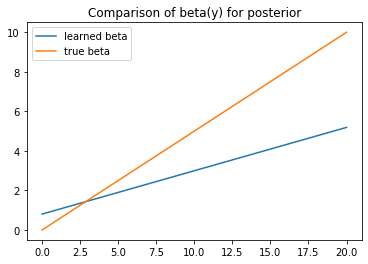

In [189]:
x =tf.linspace(
    0.001, 20, 1000, name=None, axis=0
)
x = tf.expand_dims(x,-1)

beta_y = encoder(x).scale
plt.figure()
plt.title("Comparison of beta(y) for posterior")
plt.plot(x,beta_y,label='learned beta')
plt.plot(x,0.5*x, label = 'true beta')
plt.legend(['learned beta','true beta'])


<Figure size 432x288 with 0 Axes>

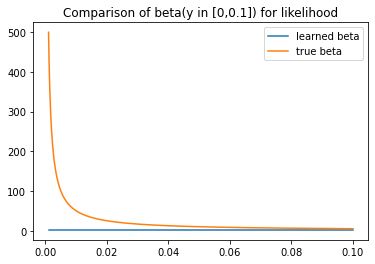

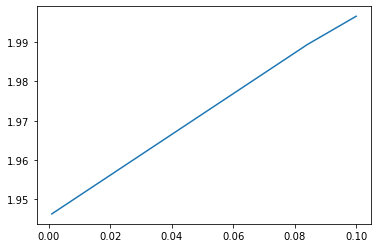

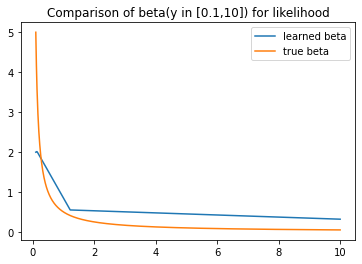

<Figure size 432x288 with 0 Axes>

In [190]:
x =tf.linspace(
    0.001, 0.1, 1000, name=None, axis=0
)
x = tf.expand_dims(x,-1)
beta_x = decoder(x).rate
plt.figure()
plt.title("Comparison of beta(y in [0,0.1]) for likelihood")
plt.plot(x,beta_x,label='learned beta')
plt.plot(x,0.5/x, label = 'true beta')
plt.legend(['learned beta','true beta'])
plt.figure()
plt.plot(x,beta_x,label='learned beta')
x =tf.linspace(
    0.1, 10, 1000, name=None, axis=0
)
x = tf.expand_dims(x,-1)
beta_x = decoder(x).rate
plt.figure()
plt.title("Comparison of beta(y in [0.1,10]) for likelihood")
plt.plot(x,beta_x,label='learned beta')
plt.plot(x,0.5/x, label = 'true beta')
plt.legend(['learned beta','true beta'])
plt.figure()


(1000,)
(1000,)


/home/nlafon/.conda/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  
/home/nlafon/.conda/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  if __name__ == '__main__':


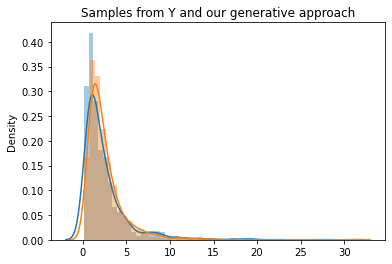

In [197]:
#Comparaison entre la densité de Y et de notre modèle génératif

samples_y = Y
print(samples_y.shape)
X_gen = prior.sample((1000,1))
samples_y_gen = tf.reshape(decoder(X_gen),(1000,))
print(samples_y_gen.shape)
sns.distplot(samples_y)
sns.distplot(samples_y_gen)
plt.title("Samples from Y and our generative approach")
plt.show()



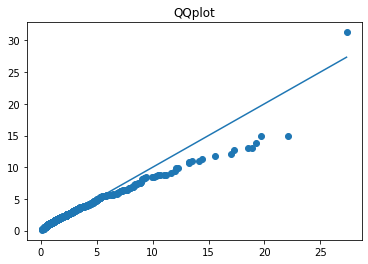

In [198]:

plt.figure()
plt.title('QQplot')
plt.scatter(tf.sort(samples_y),tf.sort(samples_y_gen))
plt.plot(tf.sort(samples_y),tf.sort(samples_y))

## Experiment 2
We generate from a multiplicative Y = AX.  
A is a gamma distribution with alpha = 3, beta = 0.5  
X is a inverse gamma distribution with alpha = 2.5, beta = 0.6  
The prior is InvGamma with alpha=2.5, beta=1   
The posterior is InvGamma with alpha constant learnable , beta learnable function of samples y  
The likelihood is a gamma distribution with alpha constant, beta learnable function of samples y  

In [16]:
zeros_traindataset=tf.zeros(train_dataset.shape)
print(zeros_traindataset.shape)

(750, 1)


In [17]:
Y_input = tfk.Input(
    shape=[1], name="Y_train"
)  
zeros_input = tfk.Input([1], name="Zeros_train")
beta_layer = tfkl.Dense(1,activation=None,use_bias = False)(Y_input)
alpha_layer = tfkl.Dense(1,use_bias=True,activation=None, bias_initializer=tfk.initializers.Ones()
)(zeros_input)
alpha_layer = tfkl.Lambda(lambda x: tf.abs(x)+0.001)(alpha_layer)
beta_layer = tfkl.Lambda(lambda x: tf.abs(x)+0.001,name = 'inv_gamma_beta_posterior')(beta_layer)
alpha_beta = tfkl.Concatenate()([alpha_layer,beta_layer])
posterior = tfpl.DistributionLambda(
    make_distribution_fn=lambda t: tfd.InverseGamma(
        concentration=t[... , 0], scale=t[...,1]),
    activity_regularizer=tfpl.KLDivergenceRegularizer(prior),
)(alpha_beta)
posterior = tfkl.Reshape(target_shape=[1])(posterior) 
print(posterior.shape)
encoder2 = tfk.Model(
    inputs=[Y_input,zeros_input],
    outputs=[posterior, alpha_layer],
)


(None, 1)


In [18]:
encoder2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Zeros_train (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 Y_train (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 1)            2           ['Zeros_train[0][0]']            
                                                                                                  
 dense_9 (Dense)                (None, 1)            1           ['Y_train[0][0]']                
                                                                                            

In [19]:
post_input = tfk.Input(
    shape=[1], name="post_input"
)  
alpha_input = tfk.Input([1], name="alpha_input")

beta_deco = tfkl.Dense(5, use_bias=True, activation='relu')(post_input)
beta_deco = tfkl.Dense(5, use_bias=True, activation='relu')(beta_deco)
beta_deco = tfkl.Dense(1, use_bias=True)(beta_deco)
beta_deco = tfkl.Lambda(lambda x: tf.abs(x)+0.001)(beta_deco)
alpha_beta = tfkl.Concatenate()([alpha_input,beta_deco])
out = tfpl.DistributionLambda(
make_distribution_fn=lambda v: tfd.Gamma(
        concentration=v[...,0], rate=v[...,1]),       
)(alpha_beta)
decoder2 = tfk.Model(
    inputs=[post_input,alpha_input],
    outputs=out
)
 #   convert_to_tensor_fn=lambda s: s.sample),


In [20]:
decoder2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 post_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 dense_11 (Dense)               (None, 5)            10          ['post_input[0][0]']             
                                                                                                  
 dense_12 (Dense)               (None, 5)            30          ['dense_11[0][0]']               
                                                                                                  
 dense_13 (Dense)               (None, 1)            6           ['dense_12[0][0]']               
                                                                                            

In [21]:
vae2 = tfk.Model(inputs=encoder2.inputs,
                outputs=decoder2(encoder2.outputs))
print(vae2.output_shape)

(None,)


In [25]:
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

vae2.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=negative_log_likelihood)

In [26]:
c=tf.constant([[1.0],[2.0]])
z = tf.constant([[0.0],[0.0]])
print(encoder2([c,z]))
[print(np.squeeze(w.numpy())) for w in encoder2.weights]

[<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[12.692244 ],
       [ 2.6507733]], dtype=float32)>, <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[1.002996],
       [1.002996]], dtype=float32)>]
-0.747965
1.0019959
-0.3795797


[None, None, None]

In [27]:
vae2.fit(
    {"Y_train" : train_dataset, "Zeros_train" : zeros_traindataset},
    train_dataset,
    validation_data = ((eval_dataset,tf.zeros(eval_dataset.shape)),eval_dataset),
         batch_size=16,epochs=100)


Epoch 1/100
47/47 [==============================] - 2s 17ms/step - loss: 5.0774 - val_loss: 4.9313
Epoch 2/100
47/47 [==============================] - 0s 8ms/step - loss: 5.4375 - val_loss: 6.1019
Epoch 3/100
47/47 [==============================] - 0s 9ms/step - loss: 4.7882 - val_loss: 4.5578
Epoch 4/100
47/47 [==============================] - 0s 8ms/step - loss: 7.6310 - val_loss: 5.1012
Epoch 5/100
47/47 [==============================] - 0s 7ms/step - loss: 4.7691 - val_loss: 4.3352
Epoch 6/100
47/47 [==============================] - 0s 8ms/step - loss: 4.3132 - val_loss: 4.0533
Epoch 7/100
47/47 [==============================] - 1s 12ms/step - loss: 4.6879 - val_loss: 4.6163
Epoch 8/100
47/47 [==============================] - 0s 9ms/step - loss: 4.5272 - val_loss: 4.5767
Epoch 9/100
47/47 [==============================] - 0s 7ms/step - loss: 4.4469 - val_loss: 4.2594
Epoch 10/100
47/47 [==============================] - 0s 7ms/step - loss: 4.4747 - val_loss: 4.6441
Epoch 1

In [28]:
layer_name = 'inv_gamma_beta_posterior'
intermediate_layer_model = tfk.Model(inputs=encoder2.input,
                                       outputs=encoder2.get_layer(layer_name).output)

tf.Tensor([1.4500233], shape=(1,), dtype=float32)


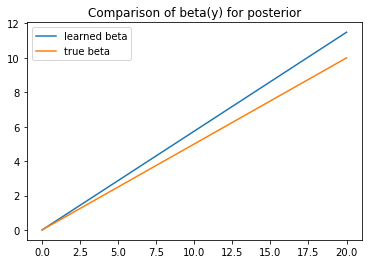

In [29]:
x =tf.linspace(
    0.001, 20, 1000, name=None, axis=0
)
x = tf.expand_dims(x,-1)

x_tot = [x,tf.zeros(x.shape)]
beta_y = intermediate_layer_model(x_tot)
print(encoder2(x_tot)[1][0])

plt.figure()
plt.title("Comparison of beta(y) for posterior")
plt.plot(x,beta_y,label='learned beta')
plt.plot(x,0.5*x, label = 'true beta')
plt.legend(['learned beta','true beta'])


<Figure size 432x288 with 0 Axes>

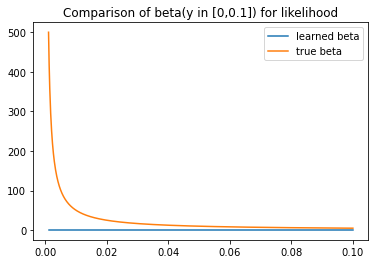

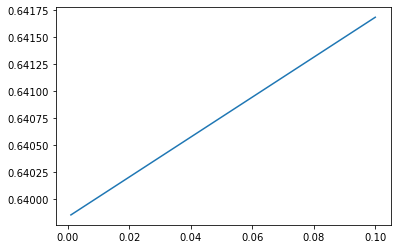

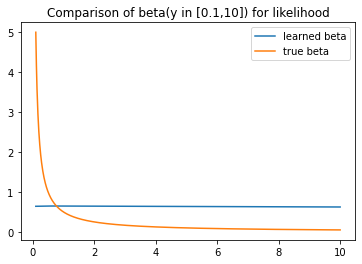

<Figure size 432x288 with 0 Axes>

In [30]:
x =tf.linspace(
    0.001, 0.1, 1000, name=None, axis=0
)
x = tf.expand_dims(x,-1)
alpha_y = encoder2(x_tot)[1]
beta_x = decoder2([x,alpha_y]).rate
plt.figure()
plt.title("Comparison of beta(y in [0,0.1]) for likelihood")
plt.plot(x,beta_x,label='learned beta')
plt.plot(x,0.5/x, label = 'true beta')
plt.legend(['learned beta','true beta'])
plt.figure()
plt.plot(x,beta_x,label='learned beta')
x =tf.linspace(
    0.1, 10, 1000, name=None, axis=0
)
x = tf.expand_dims(x,-1)
beta_x = decoder2([x,alpha_y]).rate
plt.figure()
plt.title("Comparison of beta(y in [0.1,10]) for likelihood")
plt.plot(x,beta_x,label='learned beta')
plt.plot(x,0.5/x, label = 'true beta')
plt.legend(['learned beta','true beta'])
plt.figure()

(1000,)
(1000,)


/home/nlafon/.conda/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  
/home/nlafon/.conda/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  if __name__ == '__main__':


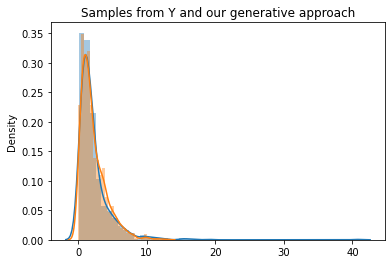

In [31]:
#Comparaison entre la densité de Y et de notre modèle génératif

samples_y = Y
print(samples_y.shape)
X_gen = prior.sample((1000,1))
samples_y_gen = tf.reshape(decoder2([X_gen,alpha_y]),(1000,))
print(samples_y_gen.shape)
sns.distplot(samples_y)
sns.distplot(samples_y_gen)
plt.title("Samples from Y and our generative approach")
plt.show()



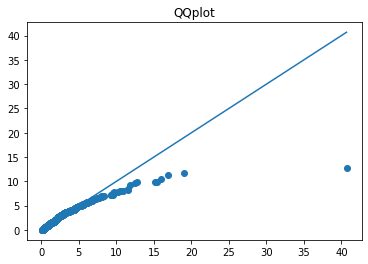

In [32]:
plt.figure()
plt.title('QQplot')
plt.scatter(tf.sort(samples_y),tf.sort(samples_y_gen))
plt.plot(tf.sort(samples_y),tf.sort(samples_y))

In [33]:
[print(np.squeeze(w.numpy())) for w in encoder2.weights]

-0.747965
1.4490232
-0.57445985


[None, None, None]

# Experiment 3

We generate from a multiplicative Y = AX.  
A is a gamma distribution with alpha = 3, beta = 0.5  
X is a inverse gamma distribution with alpha = 2.5, beta = 0.6  
The prior is InvGamma with alpha=2.5, beta=1   
The posterior is InvGamma with alpha, beta learnable function of samples y  
The likelihood is a gamma distribution with alpha, beta learnable function of samples y  

In [57]:
encoder3 = tfk.Sequential([
    tfkl.InputLayer(input_shape=[1]),
    tfkl.Dense(5,
               activation='relu'),
    tfkl.Dense(5,
               activation='relu'),
    tfkl.Dense(2,
               activation=None,
              name = 'inv_gamma_beta_posterior'),
    tfkl.Lambda(lambda x: tf.abs(x)+0.001),
])    

In [58]:
encoder3.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss='mean_absolute_error')

In [59]:
pre_target=np.zeros((train_dataset.shape[0],2))
pre_target[...,0] = pre_target[...,0] +1.5
pre_target[...,1] = pre_target[...,1] +1
encoder3.fit(train_dataset,pre_target,batch_size=16,epochs=100)

Epoch 1/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 2/100
47/47 [==============================] - 0s 4ms/step - loss: 5.4261e-04
Epoch 3/100
47/47 [==============================] - 0s 3ms/step - loss: 5.6763e-04
Epoch 4/100
47/47 [==============================] - 0s 4ms/step - loss: 6.3672e-04
Epoch 5/100
47/47 [==============================] - 0s 3ms/step - loss: 7.2210e-04
Epoch 6/100
47/47 [==============================] - 0s 3ms/step - loss: 6.8029e-04
Epoch 7/100
47/47 [==============================] - 0s 4ms/step - loss: 8.9413e-04
Epoch 8/100
47/47 [==============================] - 0s 3ms/step - loss: 4.7187e-04
Epoch 9/100
47/47 [==============================] - 0s 3ms/step - loss: 7.5795e-04
Epoch 10/100
47/47 [==============================] - 0s 4ms/step - loss: 3.8525e-04
Epoch 11/100
47/47 [==============================] - 0s 4ms/step - loss: 5.2883e-04
Epoch 12/100
47/47 [==============================] - 0s 4ms/step - loss: 0.00

In [60]:
#Afin d'initialiser l'encoder3, on lui fait apprendre le résultat obtenu à l'aide de l'encoder 2
encoder3.add( tfpl.DistributionLambda(
    make_distribution_fn=lambda t: tfd.InverseGamma(
        concentration=t[...,0], scale=t[...,1]),
    activity_regularizer=tfpl.KLDivergenceRegularizer(prior)))
encoder3.add(tfkl.Reshape(target_shape=[1]))


In [61]:
encoder3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 5)                 10        
                                                                 
 dense_24 (Dense)            (None, 5)                 30        
                                                                 
 inv_gamma_beta_posterior (D  (None, 2)                12        
 ense)                                                           
                                                                 
 lambda_8 (Lambda)           (None, 2)                 0         
                                                                 
 distribution_lambda_7 (Dist  ((None,),                0         
 ributionLambda)              (None,))                           
                                                                 
 reshape_3 (Reshape)         (None, 1)                

In [62]:
decoder3 = tfk.Sequential([
    tfkl.Dense(5, use_bias=True, activation='relu'),
    tfkl.Dense(5, use_bias=True, activation='relu'),
    tfkl.Dense(2, use_bias=True),
    tfkl.Lambda(lambda x: tf.abs(x)+0.001),
    tfpl.DistributionLambda(
    make_distribution_fn=lambda v: tfd.Gamma(
        concentration=v[...,0], rate=v[...,1])),
 #   convert_to_tensor_fn=lambda s: s.sample),
])

In [63]:
decoder3(encoder3(train_dataset))

<tfp.distributions._TensorCoercible 'sequential_6_distribution_lambda_8_tensor_coercible' batch_shape=[750] event_shape=[] dtype=float32>

In [64]:
c=tf.constant([[1.0]])
print(decoder3(c))
decoder3.summary()

tfp.distributions._TensorCoercible("sequential_6_distribution_lambda_8_tensor_coercible", batch_shape=[1], event_shape=[], dtype=float32)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 5)                 10        
                                                                 
 dense_26 (Dense)            (None, 5)                 30        
                                                                 
 dense_27 (Dense)            (None, 2)                 12        
                                                                 
 lambda_9 (Lambda)           (None, 2)                 0         
                                                                 
 distribution_lambda_8 (Dist  ((None,),                0         
 ributionLambda)              (None,))                           
                                                

In [65]:

vae3 = tfk.Model(inputs=encoder3.inputs,
                outputs=decoder3(encoder3.outputs))
print(vae3.output_shape)

(None,)


In [68]:
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

vae3.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=negative_log_likelihood)

In [69]:
vae3.fit(train_dataset,train_dataset,batch_size=16,epochs=100)


Epoch 1/100
47/47 [==============================] - 2s 4ms/step - loss: 3.2337
Epoch 2/100
47/47 [==============================] - 0s 5ms/step - loss: 2.7384
Epoch 3/100
47/47 [==============================] - 0s 5ms/step - loss: 2.8269
Epoch 4/100
47/47 [==============================] - 0s 5ms/step - loss: 2.6313
Epoch 5/100
47/47 [==============================] - 0s 5ms/step - loss: 2.6173
Epoch 6/100
47/47 [==============================] - 0s 5ms/step - loss: 2.2527
Epoch 7/100
47/47 [==============================] - 0s 5ms/step - loss: 2.3350
Epoch 8/100
47/47 [==============================] - 0s 5ms/step - loss: 2.3913
Epoch 9/100
47/47 [==============================] - 0s 5ms/step - loss: 2.2633
Epoch 10/100
47/47 [==============================] - 0s 5ms/step - loss: 2.3314
Epoch 11/100
47/47 [==============================] - 0s 5ms/step - loss: 2.1916
Epoch 12/100
47/47 [==============================] - 0s 5ms/step - loss: 2.1078
Epoch 13/100
47/47 [=================

In [72]:
layer_name = 'inv_gamma_beta_posterior'
intermediate_layer_model = tfk.Model(inputs=encoder3.input,
                                       outputs=encoder3.get_layer(layer_name).output)

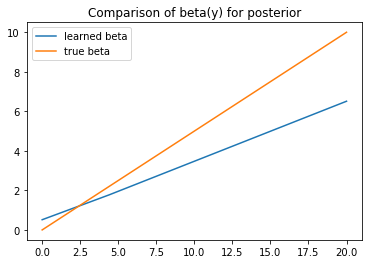

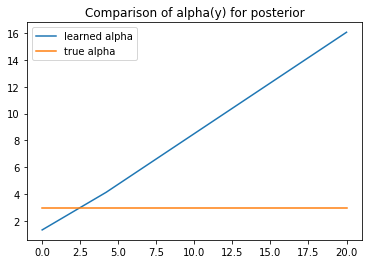

In [81]:
x =tf.linspace(
    0.001, 20, 1000, name=None, axis=0
)
x = tf.expand_dims(x,-1)

x_tot = x
alpha_beta_y = intermediate_layer_model(x_tot)
alpha_y = alpha_beta_y[...,0]
beta_y = alpha_beta_y[...,1]

plt.figure()
plt.title("Comparison of beta(y) for posterior")
plt.plot(x,beta_y,label='learned beta')
plt.plot(x,0.5*x, label = 'true beta')
plt.legend(['learned beta','true beta'])
plt.figure()
plt.title("Comparison of alpha(y) for posterior")
plt.plot(x,alpha_y,label='learned alpha')
plt.plot(x,3+tf.zeros((1000,1)), label = 'true alpha')
plt.legend(['learned alpha','true alpha'])

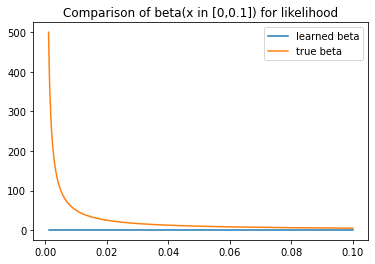

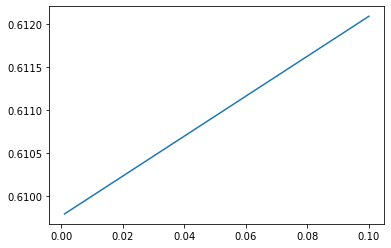

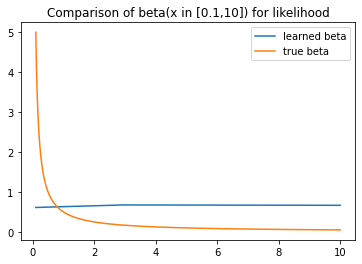

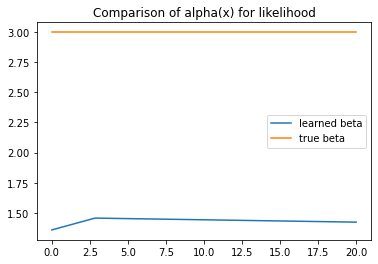

In [89]:
x =tf.linspace(
    0.001, 0.1, 1000, name=None, axis=0
)
x = tf.expand_dims(x,-1)
beta_x = decoder3(x).rate
plt.figure()
plt.title("Comparison of beta(x in [0,0.1]) for likelihood")
plt.plot(x,beta_x,label='learned beta')
plt.plot(x,0.5/x, label = 'true beta')
plt.legend(['learned beta','true beta'])
plt.figure()
plt.plot(x,beta_x,label='learned beta')
x =tf.linspace(
    0.1, 10, 1000, name=None, axis=0
)
x = tf.expand_dims(x,-1)
beta_x = decoder3(x).rate
plt.figure()
plt.title("Comparison of beta(x in [0.1,10]) for likelihood")
plt.plot(x,beta_x,label='learned beta')
plt.plot(x,0.5/x, label = 'true beta')
plt.legend(['learned beta','true beta'])
plt.figure()
alpha_x = decoder3(x_tot).concentration
plt.title("Comparison of alpha(x) for likelihood")
plt.plot(x_tot,alpha_x,label='learned alpha')
plt.plot(x_tot,3+tf.zeros((1000,1)), label = 'true alpha')
plt.legend(['learned beta','true beta'])

(1000,)
(1000,)


/home/nlafon/.conda/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  import sys
/home/nlafon/.conda/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


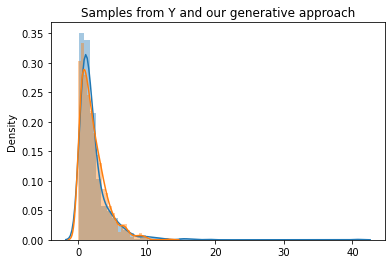

In [85]:
#Comparaison entre la densité de Y et de notre modèle génératif
samples_y = Y
X_gen = prior.sample((1000,1))
samples_y_gen = tf.reshape(decoder3(X_gen),(1000,))
sns.distplot(samples_y)
sns.distplot(samples_y_gen)
plt.title("Samples from Y and our generative approach")
plt.show()


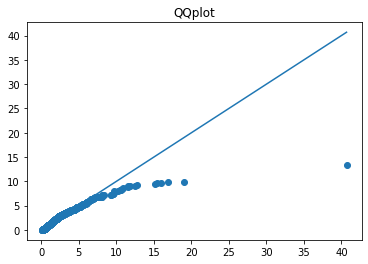

In [86]:
plt.figure()
plt.title('QQplot')
plt.scatter(tf.sort(samples_y),tf.sort(samples_y_gen))
plt.plot(tf.sort(samples_y),tf.sort(samples_y))

## Experiment 4
We generate from a multiplicative Y = AX.  
A is a gamma distribution with alpha = 3, beta = 0.5  
X is a inverse gamma distribution with alpha = 2.5, beta = 0.6  
The prior is InvGamma with alpha hyperparameter, beta=1   
The posterior is InvGamma with alpha constant learnable , beta learnable function of samples y  
The likelihood is a gamma distribution with alpha constant, beta learnable function of samples y  

In [1]:
from tensorboard.plugins.hparams import api as hp

In [ ]:
class NLL(tf.keras.metrics.Metric):
    def __init__(self, name='NLL', **kwargs):
        super(NLL, self).__init__(name=name, **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)

    values = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
    values = tf.cast(values, self.dtype)
    if sample_weight is not None:
      sample_weight = tf.cast(sample_weight, self.dtype)
      values = tf.multiply(values, sample_weight)
    self.true_positives.assign_add(tf.reduce_sum(values))

  def result(self):
    return self.true_positives

  def reset_states(self):
    self.true_positives.assign(0)

In [61]:
HP_alpha_prior = hp.HParam('num_units', hp.Discrete([1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]))

negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

METRIC_ACCURACY = 'kullback_leibler_divergence'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_alpha_prior],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='NLL')],
  )



In [66]:
def train_test_model(hparams):
    prior =tfd.InverseGamma(concentration = hparams[HP_alpha_prior], scale = 1 )
    encoder4 = tfk.Sequential([
    tfkl.InputLayer(input_shape=[1]),
    tfkl.Dense(5,
               activation='relu'),
    tfkl.Dense(5,
               activation='relu'),
    tfkl.Dense(2,
               activation=None,
              name = 'inv_gamma_beta_posterior'),
    tfkl.Lambda(lambda x: tf.abs(x)+0.001),
])    
    encoder4.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss='mean_absolute_error')
    pre_target=np.zeros((train_dataset.shape[0],2))
    pre_target[...,0] = pre_target[...,0] +1.5
    pre_target[...,1] = pre_target[...,1] +1
    encoder4.fit(train_dataset,pre_target,batch_size=16,epochs=10)
    encoder4.add( tfpl.DistributionLambda(
    make_distribution_fn=lambda t: tfd.InverseGamma(
        concentration=t[...,0], scale=t[...,1]),
    activity_regularizer=tfpl.KLDivergenceRegularizer(prior)))
    encoder4.add(tfkl.Reshape(target_shape=[1]))
    decoder4 = tfk.Sequential([
        tfkl.InputLayer(input_shape=[1]),
    tfkl.Dense(5, use_bias=True, activation='relu'),
    tfkl.Dense(5, use_bias=True, activation='relu'),
    tfkl.Dense(2, use_bias=True),
    tfkl.Lambda(lambda x: tf.abs(x)+0.001),
    tfpl.DistributionLambda(
    make_distribution_fn=lambda v: tfd.Gamma(
        concentration=v[...,0], rate=v[...,1])),
 #   convert_to_tensor_fn=lambda s: s.sample),
])  
    vae4 = tfk.Model(inputs=encoder4.inputs,
                outputs=decoder4(encoder4.outputs))
    vae4.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss=negative_log_likelihood)
    vae4.fit(train_dataset,train_dataset,batch_size=16,epochs=100)
    print(vae4.evaluate(eval_dataset, eval_dataset))
    accuracy = vae4.evaluate(eval_dataset, eval_dataset)
    return accuracy
    
  



In [67]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)


In [68]:
#vae4.evaluate(eval_dataset, eval_dataset)

In [69]:
session_num = 0

for alpha_prior in HP_alpha_prior.domain.values:
    hparams = {
          HP_alpha_prior: alpha_prior,
      }
    run_name = "run-%d" % session_num
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})
    run('logs/hparam_tuning/' + run_name, hparams)
    session_num += 1


--- Starting trial: run-0
{'num_units': 1.5}
Epoch 1/10
47/47 [==============================] - 0s 3ms/step - loss: 0.9088
Epoch 2/10
47/47 [==============================] - 0s 3ms/step - loss: 0.7507
Epoch 3/10
47/47 [==============================] - 0s 3ms/step - loss: 0.6107
Epoch 4/10
47/47 [==============================] - 0s 3ms/step - loss: 0.4965
Epoch 5/10
47/47 [==============================] - 0s 3ms/step - loss: 0.3851
Epoch 6/10
47/47 [==============================] - 0s 3ms/step - loss: 0.2738
Epoch 7/10
47/47 [==============================] - 0s 3ms/step - loss: 0.1864
Epoch 8/10
47/47 [==============================] - 0s 3ms/step - loss: 0.1294
Epoch 9/10
47/47 [==============================] - 0s 3ms/step - loss: 0.0811
Epoch 10/10
47/47 [==============================] - 0s 3ms/step - loss: 0.0367
Epoch 1/100
47/47 [==============================] - 2s 6ms/step - loss: 2.5635
Epoch 2/100
47/47 [==============================] - 0s 6ms/step - loss: 2.2868
Epoc

# Multivariate generation

## Experiment 1
Let **Y** the multivariate random vector we want to sample from. **Y** = ||**Y**|| **S**
The norm is set to the 1D Y of 1D experiments. Namely, we generate ||**Y**|| from a multiplicative ||**Y**|| = AX.  
A is a gamma distribution with alpha = 3, beta = 0.5  
X is a inverse gamma distribution with alpha = 2.5, beta = 0.6  
We sample on the multivariate sphere according to a Dirichlet distribution. 
**S** is Dirichlet with K=5, $\alpha_1=\alpha_2 = 2$, $ \alpha_3=\alpha_4 = \alpha_5=1$.

In [15]:
K=5
alphas = [2.0, 2., 1., 1., 1.]
S =tfd.Dirichlet(alphas)

In [8]:
angles = S.sample(1000)
angle_train = angles[:750,:]
angle_eval = angles[750:]

In [11]:
encoded_size = 3
prior_sphere = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)

In [13]:
encoder_sphere = tfk.Sequential([
    tfkl.InputLayer(input_shape=[5]),
    tfkl.Dense(8,
               activation='relu'),
    tfkl.Dense(8,
               activation='relu'),
    tfkl.Dense(tfpl.IndependentNormal.params_size(encoded_size)),
    tfpl.IndependentNormal(
        encoded_size,
        activity_regularizer=tfpl.KLDivergenceRegularizer(prior_sphere, weight=1.0)),
])

In [14]:
encoder_sphere.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 8)                 48        
                                                                 
 dense_9 (Dense)             (None, 8)                 72        
                                                                 
 dense_10 (Dense)            (None, 6)                 54        
                                                                 
 independent_normal_1 (Indep  ((None, 3),              0         
 endentNormal)                (None, 3))                         
                                                                 
Total params: 174
Trainable params: 174
Non-trainable params: 0
_________________________________________________________________


In [21]:
decoder_sphere  = tfk.Sequential([
    tfkl.InputLayer(input_shape=[encoded_size]),
    tfkl.Dense(5, use_bias=True, activation='relu'),
    tfkl.Dense(10, use_bias=True, activation='relu'),
    tfkl.Dense(tfpl.IndependentNormal(
        K).params_size(K)),
    tfpl.IndependentNormal(
        K)
])

In [22]:
decoder_sphere.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 5)                 20        
                                                                 
 dense_20 (Dense)            (None, 10)                60        
                                                                 
 dense_21 (Dense)            (None, 10)                110       
                                                                 
 independent_normal_5 (Indep  ((None, 5),              0         
 endentNormal)                (None, 5))                         
                                                                 
Total params: 190
Trainable params: 190
Non-trainable params: 0
_________________________________________________________________


In [23]:
vae_sphere = tfk.Model(inputs=encoder_sphere.inputs,
                outputs=decoder_sphere(encoder_sphere.outputs[0]))

In [24]:
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

vae_sphere.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=negative_log_likelihood)

In [25]:
vae_sphere.fit(angle_train,angle_train,batch_size=32,epochs=100)

Epoch 1/100
24/24 [==============================] - 2s 5ms/step - loss: 4.6095
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 3.9644
Epoch 3/100
24/24 [==============================] - 0s 5ms/step - loss: 3.4365
Epoch 4/100
24/24 [==============================] - 0s 6ms/step - loss: 3.0676
Epoch 5/100
24/24 [==============================] - 0s 7ms/step - loss: 2.7914
Epoch 6/100
24/24 [==============================] - 0s 6ms/step - loss: 2.4205
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 1.9176
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 1.4308
Epoch 9/100
24/24 [==============================] - 0s 5ms/step - loss: 0.8265
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 0.1874
Epoch 11/100
24/24 [==============================] - 0s 4ms/step - loss: -0.4362
Epoch 12/100
24/24 [==============================] - 0s 4ms/step - loss: -0.9956
Epoch 13/100
24/24 [===============

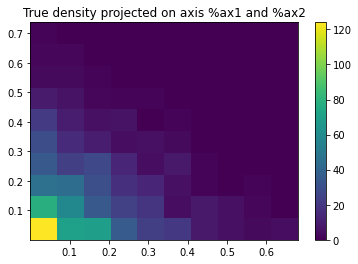

In [40]:
#Projection of the distribution on two axis
ax1 = 2
ax2 = 4
Y_1 = angles[:,ax1]
Y_2 = angles[:,ax2]
plt.figure()
plt.title('True density projected on axis %ax1 and %ax2')
h =plt.hist2d(Y_1, Y_2)
plt.colorbar(h[3])

(1000, 5)


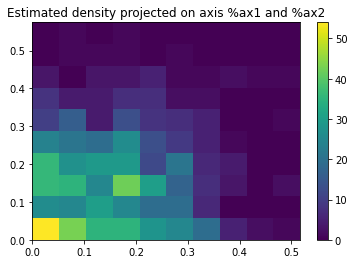

In [41]:
S_gen_prior = prior_sphere.sample((1000))
samples_S_gen = decoder_sphere(S_gen_prior)
print(samples_S_gen.shape)
S_gen1 = samples_S_gen[:,ax1]
S_gen1 = tf.maximum(S_gen1,0)
S_gen2 = samples_S_gen[:,ax2]
S_gen2 = tf.maximum(S_gen2,0)
plt.figure()
plt.title('Estimated density projected on axis %ax1 and %ax2')
h =plt.hist2d(S_gen1, S_gen2,cmin=0)
plt.colorbar(h[3])

## Experiment 2
Same data generation process as Experiment 1.
